# Message-Passing Neural Networks
### This assignment walks through how to build Message-Passing Neural Network models for two different molecular properties: atomization energy and band gap energy. We also will see how the design of a network can have a large influence on the accuracy of a machine learning model.

In [1]:
%matplotlib inline
from typing import List, Tuple
from matplotlib import pyplot as plt
from mpnn.data import make_data_loader
from mpnn.data import make_tfrecord
from sklearn.model_selection import train_test_split
from rdkit import Chem
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import mpnn
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from mpnn.layers import Readout, Squeeze, Scaling
from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler

## Question 1: Making data loaders.

Our first step to create data loaders for the training, validation, and test data from the datasets provided with this repository.

Use the make_loader function the mpnn library to create a data loader for each, with batch_size of 32. You can change the output property for each loader and a few other key settings:

In [2]:
test_loader = mpnn.data.make_data_loader('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/Datasets/test_data.proto', 
                                        batch_size=32)

train_loader = mpnn.data.make_data_loader('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/Datasets/train_data.proto', 
                                        batch_size=32, 
                                        shuffle_buffer=128)

valid_loader = mpnn.data.make_data_loader('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/Datasets/valid_data.proto', 
                                        batch_size=32)

### Q

1. It's generally a rule of thumb to enable "shuffle" when creating the training data loader. Why is that? Which parameter do you set?

       In order to enable 'shuffle' when creating the training loader we set a shuffle_buffer. This assures that we get different training data for each batch and therefore epoch. This ensures that our model gets properly trained.
      

2. Sample a few batches from the training data? What is the average of the output variable?

In [3]:
inputs, outputs = next(iter(train_loader))

sample_outputs=outputs.numpy()

for s in (0,1,3,7,15,31):
    print(f'Batch {s+1}:{sample_outputs[s]}')
    
    output_avg=np.average(sample_outputs)
print(f'\n The output average is: {output_avg}')

Batch 1:-2.674006938934326
Batch 2:-2.6162660121917725
Batch 4:-2.8316829204559326
Batch 8:-2.8804171085357666
Batch 16:-2.8419809341430664
Batch 32:-2.758903980255127

 The output average is: -2.895298957824707


## Question 2: Training a network for real

Step 1: We need to make a few modifications to the make_model function from the MPNN example notebook to build a network that will get noteworthy training accuracies:

Add a parameter that allows you change to which readout function is used for the Readout layer.

Add a Dense layer with 'relu' activation and 32 units between the readout and the output layer.

Add "scaling layer" from mpnn.layers (i.e., from mpnn.layers import Scaling) after the current output layer, use the output of the scaling layer as the output of the model. Pass your Scaling layer a name of "scaling" (i.e., Scaling(name='scaling'))

In [4]:
class MessagePassingLayer(layers.Layer):
    """Perform the message passing step"""

    def call(self, atom_features, bond_features, connectivity):
        """Perform the message passing steps.
        
        Takes the atom and bond features with the connectivity as inputs
        and produces a new set of atom features.
        """
        # Get the features for the atoms at each side of a bond
        source_atom = tf.gather(atom_features, connectivity[:, 0])
        target_atom = tf.gather(atom_features, connectivity[:, 1])

        # Make messages based on the "far side" of the bond and the bond type
        all_messages = tf.multiply(bond_features, target_atom)

        # Sum them up and add them to the original features
        messages = tf.math.segment_sum(all_messages, connectivity[:, 0])
        atom_features = atom_features + messages
        return atom_features

In [5]:
def make_model(num_features: int, num_messages: int, readout_func: str = 'sum'):
    """Build an MPNN
    
    
    Args:
        num_features: Number of features to use to describe each atom and bond
        num_messages: Number of message passing steps
    Returns:
        Keras models that generate molecule property
    """
    
    # The first step is to define which inputs to expand and their shapes/types
    node_graph_indices = layers.Input(shape=(1,), name='node_graph_indices', dtype='int32')
    atom_types = layers.Input(shape=(1,), name='atom', dtype='int32')
    bond_types = layers.Input(shape=(1,), name='bond', dtype='int32')
    connectivity = layers.Input(shape=(2,), name='connectivity', dtype='int32')

    # Squeeze the node graph and connectivity matrices
    #  Keras makes all input arrays 2D, I find it easier to deal with them as 1D vectors
    #  The squeeze operation removes the second dimension, and I use Kera's Lambda layer
    #  to quickly wrap a simple Tensorflow function
    squeeze = layers.Lambda(tf.squeeze, arguments={'axis': 1}, name='squeeze')
    snode_graph_indices = squeeze(node_graph_indices)
    satom_types = squeeze(atom_types)
    sbond_types = squeeze(bond_types)
    
    # Generate initial features for each atom and bond using embeddings
    atom_features = layers.Embedding(6, num_features, name='atom_embedding')(satom_types)
    bond_features = layers.Embedding(4, num_features, name='bond_embedding')(sbond_types)
    
    # Perform a few message passing steps
    message_layer = MessagePassingLayer(name='message_passing')
    for _ in range(num_messages):
        atom_features = message_layer(atom_features, bond_features, connectivity)
        
    # Reduce to a single set of features per molecule
    mol_features = Readout(readout_func, name='readout')(atom_features, snode_graph_indices)
    
    #
    x = layers.Dense(32, activation='relu', name='dense')(mol_features)
    
    #Create the output layer
    output = layers.Dense(1, activation='linear', name='output')(x)
    
    # Scaling
    output = Scaling(name='scaling')(output)
    
    # Create the models by defining which layers are the inputs and which are the outputs
    model = Model(inputs=[node_graph_indices, atom_types, bond_types, connectivity], outputs=output)
    return model

Step 2: build a model with 64 features, 2 message passing layers and a "sum" readout function.

In [6]:
model=make_model(64,2,'sum')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
bond (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
squeeze (Lambda)                (None,)              0           node_graph_indices[0][0]         
                                                                 atom[0][0]                       
                                                                 bond[0][0]                       
______________________________________________________________________________________________

Step 3: Pre-seed the value of the scaling layer with the mean and value of a batch from the training dataset.

In [7]:
scale = model.get_layer('scaling')
scale.mean = outputs.numpy().mean()
scale.std = outputs.numpy().std()

Step 4: Fit the model using an early stopping callback.

Use both the training and validation loaders. Run for 128 epochs with a batch size of 32 with an early stopping patience of 8 epochs. Make sure to use restore_best_weights=True in your callback.

In [8]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=8,
    verbose=False,
    restore_best_weights=True,
)

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(train_loader, epochs=128, batch_size=32, 
                    callbacks=[callback], verbose=True, 
                    validation_data=(valid_loader)
                   )
y_pred = model.predict(train_loader)

Epoch 1/128


C:\Users\ascoh\Anaconda3\envs\applied-ai\lib\site-packages\tensorflow\python\keras\engine\functional.py:595: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_graph_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
C:\Users\ascoh\Anaconda3\envs\applied-ai\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/message_passing/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/message_passing/Reshape_2:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/message_passing/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\Users\ascoh\Anaconda3\envs\applied-ai\lib\site-packages\tensorflow\python\fram

633/633 [==============================] - 4s 4ms/step - loss: 0.0478 - val_loss: 0.0298
Epoch 2/128
633/633 [==============================] - 2s 3ms/step - loss: 0.0249 - val_loss: 0.0200
Epoch 3/128
633/633 [==============================] - 2s 3ms/step - loss: 0.0175 - val_loss: 0.0111
Epoch 4/128
633/633 [==============================] - 2s 3ms/step - loss: 0.0094 - val_loss: 0.0045
Epoch 5/128
633/633 [==============================] - 3s 4ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 6/128
633/633 [==============================] - 2s 3ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 7/128
633/633 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 9.4456e-04
Epoch 8/128
633/633 [==============================] - 2s 4ms/step - loss: 0.0011 - val_loss: 9.3879e-04
Epoch 9/128
633/633 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 10/128
633/633 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 

In [10]:
print("Evaluate on test data")
Eval = model.evaluate(test_loader)
print("test loss, test acc:", Eval)

Evaluate on test data
79/79 [==============================] - 1s 2ms/step - loss: 6.4971e-04
test loss, test acc: 0.0006497114663943648


Now, repeat steps 2-4 with 0, 1, 4 and 8 message passing layers (please use verbose=False when fitting, so the notebooks aren't huge):

In [11]:
Networks={}
scales={}
for i in tqdm([0,1,4,8]):    
    Networks[f'model_{i}']=make_model(64,i)
    
    scales[f'scale_{s}'] = Networks[f'model_{i}'].get_layer('scaling')
    scales[f'scale_{s}'].mean = outputs.numpy().mean()
    scales[f'scale_{s}'].std = outputs.numpy().std()
    
    Networks[f'model_{i}'].compile('adam', loss='mean_squared_error')
    Networks[f'model_{i}'].fit(train_loader, epochs=128, batch_size=32, callbacks=[callback], verbose=False)

 25%|█████████████████████                                                               | 1/4 [00:31<01:34, 31.51s/it]C:\Users\ascoh\Anaconda3\envs\applied-ai\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_2/message_passing/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_2/message_passing/Reshape_2:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model_2/message_passing/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
 50%|██████████████████████████████████████████                                          | 2/4 [01:43<01:50, 55.10s/it]C:\Users\ascoh\Anaconda3\envs\applied-ai\lib\site-packages\tensorflow\python\framework\indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(Inde

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [06:55<00:00, 103.88s/it]


Plot the change in the best loss on the test set as a function of number of layers.

In [12]:
results={}
print("Evaluate on test data")
for r in (0,1,4,8):
    results[f'Eval_{r}'] = Networks[f'model_{r}'].evaluate(test_loader, batch_size=128, verbose=False)
    results['Eval_2'] = Eval
print("test loss:", results)

Evaluate on test data
test loss: {'Eval_0': 0.0016590234590694308, 'Eval_2': 0.0006497114663943648, 'Eval_1': 0.0007103256648406386, 'Eval_4': 0.0012037598062306643, 'Eval_8': 0.001457061618566513}


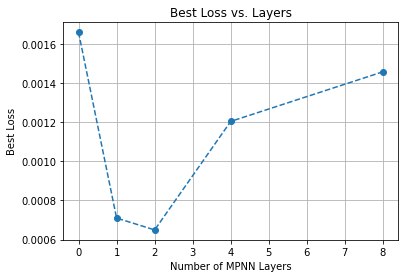

In [13]:
fig, ax = plt.subplots()

ax.plot((0,1,2,4,8),(results['Eval_0'],results['Eval_1'],results['Eval_2'],results['Eval_4'],results['Eval_8']), '--o')
ax.set_ylabel('Best Loss')
ax.set_xlabel('Number of MPNN Layers')
ax.set_title('Best Loss vs. Layers')

ax.grid(True)

 ### Q
 
 1. Do you observe a continual increase with the number of layers?
 
         No, after 2 layers the model no longer improves after two layers. This indicates that increased complexity is no longer beneficial to the model.

## Question 3: Evaluate different readout layers

All of our previous questions used the atomization energy as an output. Atomization energy generally increases with the size of the molecule because there are more bonds to break. So, our choice of summation for the readout function is a good one: more atoms means bigger sums and larger predicted values.

Band gaps, on the other hand, do not have such a scaling behavior. They are instead due to a property of two specific atoms in the molecule: one that has a high-energy occupied orbital and a second that has a low-energy unoccupied orbital.

In this problem, we will explore the effect of changing the "Readout function."

Train a total of 4 models each with 4 message passing steps and 64 features but varying whether we use u0_atom or bandgap to fit the model and whether we use "sum" or "max" as a readout function:

In [14]:
SumMax={}
SumMax['model_atom_sum']=make_model(64,4,'sum')
SumMax['model_atom_max']=make_model(64,4,'max')
SumMax['model_bandgap_sum']=make_model(64,4,'sum')
SumMax['model_bandgap_max']=make_model(64,4,'max')
R_Models = sorted(SumMax)
R_Models

['model_atom_max', 'model_atom_sum', 'model_bandgap_max', 'model_bandgap_sum']

In [20]:
atom_loader = mpnn.data.make_data_loader('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/Datasets/train_data.proto', 
                                        batch_size=32, 
                                        shuffle_buffer=128, output_property = 'u0_atom')
atom_test_loader = mpnn.data.make_data_loader('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/Datasets/test_data.proto', 
                                        batch_size=32, 
                                        output_property = 'u0_atom')
atom_valid_loader = mpnn.data.make_data_loader('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/Datasets/valid_data.proto', 
                                        batch_size=32, 
                                        output_property = 'u0_atom')


bandgap_loader = mpnn.data.make_data_loader('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/Datasets/train_data.proto', 
                                        batch_size=32, 
                                        shuffle_buffer=128, output_property = 'bandgap')
bandgap_test_loader = mpnn.data.make_data_loader('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/Datasets/test_data.proto', 
                                        batch_size=32, 
                                        output_property = 'bandgap')
bandgap_valid_loader = mpnn.data.make_data_loader('C:/Users/ascoh/Desktop/UChicago/Academics/2020-21/Q2 2021/AI for MatSci/Datasets/valid_data.proto', 
                                        batch_size=32, 
                                        output_property = 'bandgap')

In [23]:
readout_func = ('Max','Sum','Max','Sum')
scales={}
y_pred={}
y_true={}
Full = []
for s in tqdm(range(len(R_Models))):
    if s<2:
        train_selection = atom_loader
        test_selection = atom_test_loader
        valid_selection = atom_valid_loader
        feat = 'u0_atom'
    else:
        train_selection = bandgap_loader
        test_selection = bandgap_test_loader
        valid_selection = bandgap_valid_loader
        feat = 'bandgap'
        
    SumMax[f'{R_Models[s]}'].compile(optimizer='adam', loss='mean_squared_error')
    SumMax[f'{R_Models[s]}'].fit(train_selection, epochs=128, batch_size=32, 
                    callbacks=[callback], verbose=False, 
                    validation_data=(valid_loader)
                   )
    
    inputs, outputs = next(iter(train_selection))
    scales[f'scale_{s}'] = SumMax[f'{R_Models[s]}'].get_layer('scaling')
    scales[f'scale_{s}'].mean = outputs.numpy().mean()
    scales[f'scale_{s}'].std = outputs.numpy().std()
    
    y_pred[f'{R_Models[s]}']=SumMax[f'{R_Models[s]}'].predict(test_selection)[:,0]
    
    y_true[f'{R_Models[s]}'] = np.concatenate([output[1] for output in test_selection])
    
    Full.append({
        'model': R_Models[s],
        'feature': feat,
        'readout':readout_func[s],
        'y_true': y_true[f'{R_Models[s]}'],
        'y_pred': y_pred[f'{R_Models[s]}']
    })

Full = pd.DataFrame(Full)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:52<00:00, 88.20s/it]


Plot the predicted vs actual values for each of the networks on the test set.

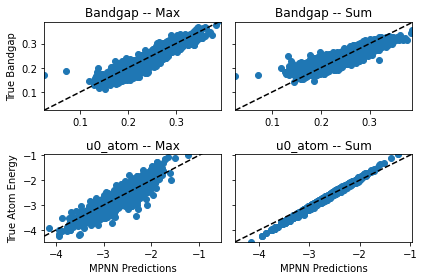

In [28]:
fig, axxs = plt.subplots(2, 2, sharey='row')

for (feature, group), axs in zip(Full.groupby('feature'), axxs):
    for (readout_func, loc), ax in zip(group.groupby('readout'), axs):
        loc = loc.iloc[0]
        ax.scatter(loc['y_true'], loc['y_pred'])       
        
        ax.set_xlim([np.concatenate(loc[['y_true', 'y_pred']]).min(),
                   np.concatenate(loc[['y_true', 'y_pred']]).max()])
        ax.set_ylim(ax.get_xlim())
        
        ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
        
        

axxs[1,0].set_xlabel('MPNN Predictions')
axxs[1,1].set_xlabel('MPNN Predictions')

axxs[0,0].set_ylabel('True Bandgap')
axxs[1,0].set_ylabel('True Atom Energy')

        
axxs[0,0].set_title('Bandgap -- Max')
axxs[1,0].set_title('u0_atom -- Max')
axxs[0,1].set_title('Bandgap -- Sum')
axxs[1,1].set_title('u0_atom -- Sum')
     
fig.tight_layout()

In [25]:
Full['mae']=[np.abs(Full['y_true'][x]-Full['y_pred'][x]).mean() for x in range(len(Full))]
Full[['model', 'mae']]

,model,mae
0,model_atom_max,0.154830
1,model_atom_sum,0.076068
2,model_bandgap_max,0.012342
3,model_bandgap_sum,0.015044


### Q

1. Explain how the max readout function produces features that do not scale with molecule size.

       The max readout function returns only the maximum values from each segment of a tensor. Thus, size is not an argurment of the function, only numerical value. As a molecule increases in size, this causes the number of values within a tensor to rise, but not the relative weight of each value, thereby preserving the maximum value.

2. Which readout performs better for each output?

       For the atomization energy, the sum readout function performs better. For bandgap, the sum performs worse while the max performs better. This is because atomization energy generally increases with atom size. Thus, summing over array segments trains the model to appropriately correlate large atomization energies and large atoms. For bandgap, however, the relation is more subtle. Rather than being dependent upon size, bandgap is dependent on the orbitals of neighboring atoms. In order for the Message Passing Network to recognize this behavior, it must prioritize values of certain atom classifications over just raw size increase - this makes the max function suitable. These relationships can be seen by observing the calculuted MAE in the dataframe above.

In [49]:
print(f'For Bandgap Energy, the Softmax Energy has a lower MAE by')
print(Full['mae'][3]-Full['mae'][2])

For Bandgap Energy, the Softmax Energy has a lower MAE by
0.002702031284570694
